In [75]:
import numpy as np
import pandas as pd
import gensim
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
import urllib.request
import shutil
import os
import random
import gensim.downloader
from gensim.models.keyedvectors import KeyedVectors
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Word embeddings

## Listar modelos pre-entrenados disponibles en Gensim

In [4]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [5]:
# si quisieramos descargar uno, ejecutar la siguiente sentencia
#glove_vectors = gensim.downloader.load('glove-twitter-25')

[==================================================] 100.0% 104.8/104.8MB downloaded


## Carga modelo pre-entrenado

Usaremos un modelo pre-entrenado en español disponible en el siguiente repositorio: <https://github.com/dccuchile/spanish-word-embeddings>. Para nuestro caso, utilizaremos el ``FastText embeddings from SBWC``

In [15]:
wordvectors_file_vec = 'fasttext-sbwc.3.6.e20.vec'

In [16]:
# cantidad = 100000 
wordvectors = KeyedVectors.load_word2vec_format(wordvectors_file_vec)

## Palabras más similares y analogías

Los embeddings son capaces de codificar información del contexto de las palabras en vectores, por lo que tenemos disponible ciertas funciones vectoriales para ciertas tareas.

### Términos más similares

In [42]:
wordvectors.most_similar('hombre', topn=10)

[('anciano', 0.6532875895500183),
 ('muchacho', 0.6404476761817932),
 ('varón', 0.6309205293655396),
 ('individuo', 0.6268893480300903),
 ('joven', 0.6027082800865173),
 ('hombree', 0.6007208824157715),
 ('mujer', 0.5953878164291382),
 ('hombres', 0.5853502154350281),
 ('indigente', 0.5837392210960388),
 ('jovencito', 0.580890953540802)]

In [43]:
wordvectors.most_similar('mujer', topn = 10)

[('niña', 0.6718433499336243),
 ('mujera', 0.6388276815414429),
 ('mujeres', 0.6201333403587341),
 ('hombre', 0.5953877568244934),
 ('mujers', 0.5783287286758423),
 ('marido', 0.5680555701255798),
 ('muchacha', 0.5595178008079529),
 ('mujerse', 0.5586514472961426),
 ('mujere', 0.5529941916465759),
 ('adolescente', 0.5462560653686523)]

In [40]:
wordvectors.most_similar('doctor', topn = 10)

[('doctoro', 0.7402119636535645),
 ('doctoré', 0.6976317763328552),
 ('doctora', 0.6914691925048828),
 ('doctores', 0.668314516544342),
 ('dr', 0.657386839389801),
 ('profesor', 0.6322946548461914),
 ('cirujano', 0.6235553622245789),
 ('catedrático', 0.6097984313964844),
 ('licenciado', 0.6047168374061584),
 ('neurocirujano', 0.6024907827377319)]

In [41]:
wordvectors.most_similar('doctora', topn = 10)

[('neuróloga', 0.7426453232765198),
 ('profesora', 0.7331705689430237),
 ('psicóloga', 0.7246388792991638),
 ('catedrática', 0.7205197811126709),
 ('cardióloga', 0.7068800330162048),
 ('viróloga', 0.7002931237220764),
 ('doctorada', 0.6974771618843079),
 ('doctoras', 0.6915507912635803),
 ('doctor', 0.691469132900238),
 ('bióloga', 0.6903846263885498)]

### Analogías

Analogías consisten en comparar 3 términos mediante una operación del estilo:

$$palabra1 - palabra2 \approx x- palabra3$$

$$palabra1 - palabra2 + palabra3 \approx x $$

In [34]:
wordvectors.most_similar(positive = ['paris', 'alemania'], negative = ['francia'], topn = 5)

[('berlin', 0.7378180623054504),
 ('münchen', 0.7009305357933044),
 ('dresden', 0.6813312768936157),
 ('frankfurt', 0.6787689328193665),
 ('munich', 0.6744019985198975)]

In [36]:
wordvectors.most_similar(positive = ['rey', 'mujer'], negative = ['hombre'], topn = 5)

[('reina', 0.6306586265563965),
 ('infanta', 0.5454354882240295),
 ('princesa', 0.5346059203147888),
 ('berenguela', 0.5296739339828491),
 ('consorte', 0.5245280265808105)]

In [37]:
wordvectors.most_similar(positive = ['doctor', 'mujer'], negative = ['hombre'], topn = 5)

[('doctora', 0.6580489277839661),
 ('oncóloga', 0.5702902674674988),
 ('ginecóloga', 0.5485242605209351),
 ('doctoré', 0.5280942320823669),
 ('doctorada', 0.5272044539451599)]

In [93]:
wordvectors.most_similar(positive = ['niño', 'perro'], negative = ['hombre'], topn = 5)

[('cachorro', 0.5529180765151978),
 ('perrito', 0.49059659242630005),
 ('cachorrito', 0.4870520532131195),
 ('gatito', 0.48580196499824524),
 ('niños', 0.4783463180065155)]

In [59]:
def construct_tsne(term, wmodel, topnw = 20):
        embeddings = []
        words = []
        for similar_word, _ in wmodel.most_similar(term, topn=topnw):
                words.append(similar_word)
                embeddings.append(wmodel[similar_word])
        embedding_clusters = np.array(embeddings)
        #print(embedding_clusters.shape)
        tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32).fit_transform(embedding_clusters)
        return words, tsne_model_en_2d
        n, m, k = embedding_clusters.shape
        
        embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
        return embeddings_en_2d, words

In [73]:
def construct_tsne(keys, wmodel, topnw = 20):
    embedding_clusters = []
    word_clusters = []
    for word in keys:
        embeddings = []
        words = []
        for similar_word, _ in wmodel.most_similar(word, topn=topnw):
            words.append(similar_word)
            embeddings.append(wmodel[similar_word])
        embedding_clusters.append(embeddings)
        word_clusters.append(words)

    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
    embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
    return embeddings_en_2d, word_clusters

In [90]:
embeddings, words= construct_tsne(['hombre', 'perro'], wordvectors, 10)

c:\Users\USUARIO\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\USUARIO\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [116]:
from matplotlib.colors import rgb2hex
import matplotlib.patches as mpatches
def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, fsize = (16,9)):
    fig = plt.figure(figsize=fsize, dpi = 144)
    ax = fig.add_subplot(111)
    p = []
    colors = []
    colors.append(list(map(rgb2hex, sns.color_palette('Oranges', n_colors=len(labels))))[1])
    colors.append(list(map(rgb2hex, sns.color_palette('Purples', n_colors=len(labels))))[1])
    #colors = color.reshape(1,-1)
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        ax.scatter(x, y, alpha=a, label=label, s = 40, color = color)
        for i, word in enumerate(words):
            p.append(ax.annotate(word, xy = (x[i], y[i]), size = 8))

    legend1 = mpatches.Patch(color=colors[0], label=labels[0])
    legend2 = mpatches.Patch(color=colors[1], label=labels[1])
    plt.legend(handles = [legend1, legend2], loc='upper right', prop={'size': 8})
    plt.title(title, fontsize = 10)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.grid(False)

    plt.show()

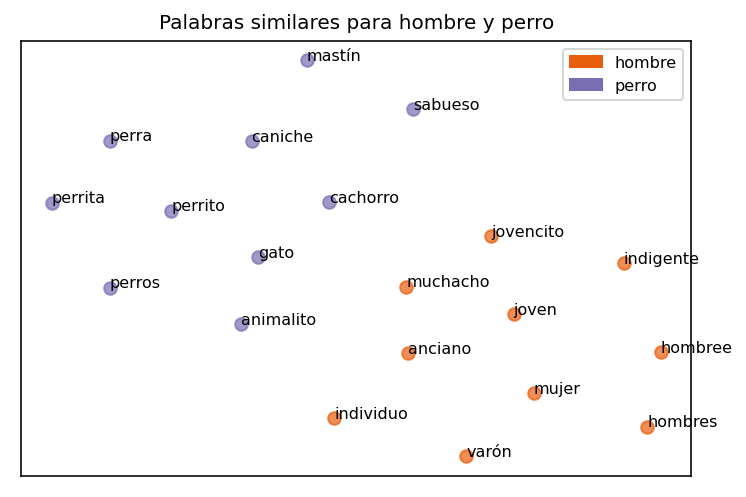

In [101]:
tsne_plot_similar_words('Palabras similares para hombre y perro', ['hombre', 'perro'], embeddings, words, 0.7, fsize = (6,4))

## Promediar vectores para representar texto

In [103]:
def document_to_vectors(word2vec_model, doc, type = "mean"):
    doc = [word for word in doc if word in word2vec_model]
    if len(doc) > 0:
        if type == "mean":
            return np.mean(word2vec_model[doc], axis=0)
        elif type == "min":
            return np.min(word2vec_model[doc], axis=0)
        elif type == "max":
            return np.max(word2vec_model[doc], axis=0)
        else:
            return np.median(word2vec_model[doc], axis=0)

In [139]:
docs = ['el perro camina', 'el avion vuela muy alto', 'el perro corre', 'el avion despego']

In [140]:
wvdocs = list()
i = 0
for d in docs:
    wvd = document_to_vectors(wordvectors, d.split())
    try:
        if wvd.any():
            wvdocs.append(wvd)
    except:
        i+=1
        pass


In [143]:
print("palabras fuera del vocabulario:",i)

palabras fuera del vocabulario: 0


In [137]:
embeddings_docs = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32).fit_transform(wvdocs)

c:\Users\USUARIO\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\USUARIO\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [130]:
embeddings_docs

array([[  51.575962 ,  161.95859  ],
       [-103.835526 ,  107.16044  ],
       [ -49.028545 ,  -48.24791  ],
       [ 106.38294  ,    6.5502105]], dtype=float32)

In [131]:
def tsne_plot_2d_docs(title, embeddings1, texts, a, fsize = (16,9)):
    fig = plt.figure(figsize=fsize, dpi = 144)
    ax = fig.add_subplot(111)
    p = []
    colors = []
    colors.append(list(map(rgb2hex, sns.color_palette('Oranges', n_colors=2)))[1])
    x = embeddings1[:, 0]
    y = embeddings1[:, 1]
    ax.scatter(x, y, alpha=a, s = 40, color = colors[0])

    for i, word in enumerate(texts):
        p.append(ax.annotate(word, xy = (x[i], y[i]), size = 8))

    plt.title(title, fontsize = 10)
    #ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

    ax.grid(False)

    plt.show()

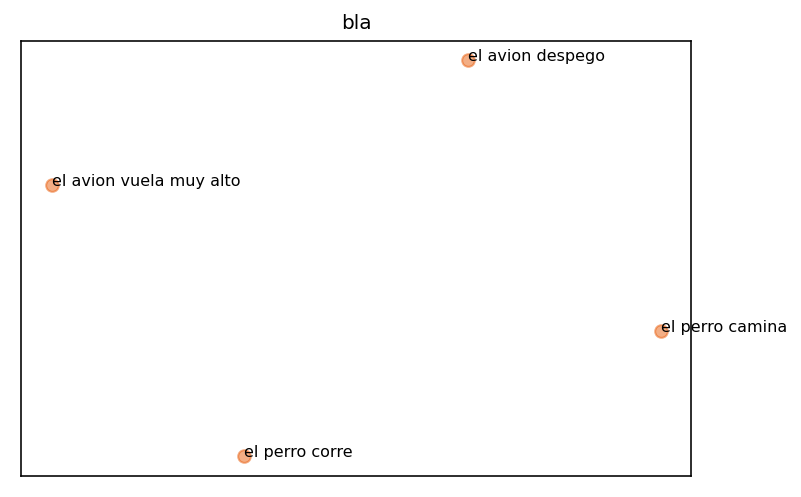

In [141]:
tsne_plot_2d_docs('bla', embeddings_docs,docs, 0.5, (6,4))